In [1]:
import os
import argparse
import numpy as np
import torch.utils.data
from glob import glob
from PIL import Image
from tqdm import tqdm
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import misc
import time
from IPython import display
import gc
import json

import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset
import torch.nn.functional as F

In [3]:
## сохранение модели
save_dir = 'test/'
def save_model(net, optim, epoch, ckpt_fname):                                                                                                                                                             
    state_dict = net.state_dict()                                                                                                                                                                         
    for key in state_dict.keys():                                                                                                                                                                                
        state_dict[key] = state_dict[key].cpu()                                                                                                                                                                  

    torch.save({                                                                                                                                                                                                 
        'epoch': epoch,                                                                                                                                                                                     
        'state_dict': state_dict,                                                                                                                                                                                
        'optimizer': optim},                                                                                                                                                                                     
        ckpt_fname)


In [4]:
if not os.path.exists('DAVIS'):
    print("images not found, donwloading...")
    os.system("wget https://data.vision.ee.ethz.ch/csergi/share/davis/DAVIS-2017-trainval-480p.zip -O DAVIS-data.zip")
    print("extracting...")
    os.system("unzip -a DAVIS-data.zip && rm DAVIS-data.zip")
    print("done")
    assert os.path.exists('DAVIS')

In [5]:
def get_dataset(names_dir):
        # get video names
        file = open(names_dir,'r') 
        names = file.readlines()
        
        # get the images
        imgs = []
        maps = []
        for name in names:  
            maps.append(sorted(glob(os.path.join('./DAVIS/Annotations/480p', name[:-1],  '*'))))
            imgs.append(sorted(glob(os.path.join('./DAVIS/JPEGImages/480p', name[:-1],  '*'))))
        return imgs, maps
    
train_data = get_dataset('DAVIS/ImageSets/2017/train.txt')
val_data = get_dataset('DAVIS/ImageSets/2017/val.txt')

train_data_size = 0
val_data_size = 0

for i in range(len(train_data[0])):
    train_data_size += len(train_data[0][i])
for i in range(len(val_data[0])):
    val_data_size += len(val_data[0][i])

print("train data size = ",train_data_size)
print("val_data_size = ",val_data_size)

train_length = np.zeros(len(train_data[0]),dtype = int)
val_length = np.zeros(len(val_data[0]),dtype = int)

train data size =  4209
val_data_size =  1999


In [6]:
#pre-load dataset to speed up further data preparations
def_h = 480
def_w = 840

train_counter = 0
val_counter = 0
n_channels = 3

Train_data_seg = np.zeros((train_data_size,def_h,def_w), dtype = np.uint8)
Val_data_seg = np.zeros((val_data_size,def_h,def_w), dtype = np.uint8)

for i in range(len(train_data[1])):
  #number of frames in this particular video
  train_length[i] = len(train_data[1][i])
  for j in range(train_length[i]):
    seg = np.asarray(Image.open(train_data[1][i][j])).copy()
    h,w = seg.shape
    #we want to work only with 480 x 848 images
    if w != def_w:
      step = (w-def_w) // 2
      if (w - def_w) % 2 == 0:
        seg = seg[:,step:w-step]
      else:
        seg = seg[:,step+1:w-step]
    #binary segmentation
    seg[seg > 0] = 1
    Train_data_seg[train_counter,:,:] = seg  
    train_counter += 1
    
for i in range(len(val_data[1])):
  #number of frames in this particular video
  val_length[i] = len(val_data[1][i])
  for j in range(val_length[i]):
    seg = np.asarray(Image.open(val_data[1][i][j])).copy()
    h,w = seg.shape
    #we want to work only with 480 x 848 images
    if w != def_w:
      step = (w-def_w) // 2
      if (w - def_w) % 2 == 0:
        seg = seg[:,step:w-step]
      else:
        seg = seg[:,step+1:w-step]
    #binary segmentation
    seg[seg > 0] = 1
    Val_data_seg[val_counter,:,:] = seg  
    val_counter += 1

In [7]:
train_length_cum = np.zeros(len(train_data[0]),dtype = int)
val_length_cum = np.zeros(len(val_data[0]),dtype = int)

train_length_cum = np.cumsum(train_length) - train_length
val_length_cum = np.cumsum(val_length) - val_length

print(train_length_cum)
print(val_length_cum)

[   0   82  172  247  334  405  485  565  654  717  801  853  913  975
 1051 1076 1162 1245 1309 1400 1480 1560 1640 1715 1775 1843 1923 2023
 2088 2161 2213 2283 2353 2433 2503 2563 2606 2652 2722 2760 2810 2900
 2935 3015 3106 3181 3249 3329 3395 3443 3534 3605 3660 3720 3790 3866
 3946 4005 4070 4137]
[   0   69  119  199  283  373  448  488  592  682  742  808  860  910
 1000 1078 1128 1209 1243 1293 1340 1389 1439 1518 1558 1638 1738 1817
 1860 1900]


In [8]:
class S2SNew(nn.Module):
    def __init__(self, n_classes=2, input_frames=4, output_frames=1, mod_size=4):
        super(S2SNew, self).__init__()
        """
        :param input_frames: integer, number of previous frames
        :param output_frames: integer, number of future frames to predict (semntoc segmentation)
        :param n_classes: integer, number of classes in semantic segmentation (for now only 2)
        """
        self.n_classes = n_classes
        self.input_frames = input_frames
        self.output_frames = output_frames
        self.mod_size = mod_size
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.softmax = nn.Softmax2d()
        # Layer 1 (reduced image)
        self.conv_net_1 = nn.Sequential(nn.Conv2d(self.input_frames, self.mod_size * 32, 
                                                  kernel_size = 3, padding = 1),
                                   nn.ReLU(),
                                   nn.Conv2d(self.mod_size*32, self.mod_size*64, 3, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(self.mod_size*64, self.mod_size*32, 3, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(self.mod_size*32, self.output_frames, 3, padding=1),
                                   nn.Sigmoid(),
                                   nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True))
        # Layer 2 (full image + prediction from layer 1)
        self.conv_net_2 = nn.Sequential(nn.Conv2d(self.input_frames + self.output_frames,
                                                  self.mod_size * 32, kernel_size = 5, padding=2),
                                   nn.ReLU(),
                                   nn.Conv2d(self.mod_size*32, self.mod_size*64, 3, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(self.mod_size*64, self.mod_size*32, 3, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(self.mod_size*32, self.output_frames, 5, padding=2),
                                   nn.Sigmoid())

        
    def forward(self, x):
        """
        Encodes inputs to hidden representations and decodes back.

        x: inputs, Variable of shape (batch_size, inp_size)
        return: reconstructed objects, Variable of shape (batch_size, inp_size)
        """
        x_reduced = self.maxpool(x)
        layer_1_result = self.conv_net_1(x_reduced)
        result = self.conv_net_2(torch.cat((x, layer_1_result), dim=1))
        result = (result + layer_1_result) * 0.5 # skip connection
        #return self.softmax(result)
        return result

In [9]:
def generate_batches_AR(dataset, X_seg, cumul, n_frames = 1,batch_size = 1, n_out = 1, repetitions = 5):
    """
    Randomly draw videos and divide it to sequences of `n_frames` consecutive frames 
        with their semantic segmentation
        
    (`n_frames` + 1)th frame segmentation is to be predicted (target)
    """  
    video_nums = np.random.permutation(np.repeat(np.arange(len(cumul)), repetitions))
    for vid in video_nums:  
        X_batch = []
        y_batch = []
        start = np.random.randint(0, len(dataset[0][vid]) - n_frames - n_out + 1,size = batch_size)
        for out in range(n_out):
            loc_X = []
            loc_y = []
            for b in range(batch_size):         
                #start index of the video frame
                start_ind = cumul[vid] + start[b]
        
                seg = X_seg[start_ind+out:start_ind+n_frames+out+1,:,:]
        
                seg = torch.from_numpy(seg).float()
                
                n,h,w = seg.size()            
              
                loc_X.append(seg[:-1,:,:])
                loc_y.append(seg[-1,:,:])
            X_batch.append(torch.stack(loc_X))
            y_batch.append(torch.stack(loc_y))
        #note that it is 5-dim tensor, not 4-dim
        yield torch.stack(X_batch), torch.stack(y_batch)

In [10]:
def fast_hist(pred, label, n=2):
    k = (label >= 0) & (label < n)
    return np.bincount(n * label[k] + pred[k], minlength=n ** 2).reshape(n, n)
#         n * label[k].astype(int) + pred[k], minlength=n ** 2).reshape(n, n)

def per_class_iu(hist):
    return np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))

def compute_metrics(pred,label,n_classes):
    """
    pred,label = np.array, shape = (batch_size,H,W), entries \in [0,n_classes-1]
    """
    iou = np.zeros(n_classes,dtype = float)
    accuracy = []
    for i in range(pred.shape[0]):
        hist = fast_hist(pred[i,:,:],label[i,:,:],n_classes)
        iou += per_class_iu(hist)
        accuracy.append(np.diag(hist).sum()/hist.sum())
    iou = iou / pred.shape[0]
    mean_iou = iou.mean()
    mean_accuracy = np.mean(accuracy)
    return mean_accuracy,mean_iou,iou

In [11]:
def compute_loss(out,h,w,labels,loss = 'BCE', eps=1e-3):
    if loss == 'BCE':
        return F.binary_cross_entropy(out,labels).mean()
    if loss == 'gdl1':
        loss_gdl = torch.sum(torch.mean(torch.abs(torch.abs(out[:,:,:h-1,:] - out[:,:,1:,:]) - torch.abs(labels[:,:,:h-1,:] - labels[:,:,1:,:]))),
            torch.mean(torch.abs(torch.abs(out[:,:,:,:w-1] - out[:,:,:,1:]) - torch.abs(labels[:,:,:,:w-1] - labels[:,:,:,1:]))))
        return loss_gdl
    if loss == 'l1':
        return F.l1_loss(out,labels)
    if loss == 'combined':
        loss_gdl = torch.sum(torch.mean(torch.abs(torch.abs(out[:,:,:h-1,:] - out[:,:,1:,:]) - torch.abs(labels[:,:,:h-1,:] - labels[:,:,1:,:]))),
             torch.mean(torch.abs(torch.abs(out[:,:,:,:w-1] - out[:,:,:,1:]) - torch.abs(labels[:,:,:,:w-1] - labels[:,:,:,1:]))))
        return loss_gdl + F.l1_loss(out,labels)
    if loss == 'dice':
        batch_losses = torch.zeros(out.shape[0])
        for i in range(out.shape[0]):
            x = torch.dot(out[i].view(-1),labels[i].view(-1))
            batch_losses[i] = - torch.log(2*x/(torch.norm(out[i],2)**2 + torch.norm(labels[i],2)**2) + eps)
        return batch_losses.mean()

## Full

In [12]:
def generate_batches_AR_all_indices(dataset, cumul, n_frames=1, 
                                    n_out=1, step=1):
    """
    generates start indices
    """
    indices = []
    for vid in range(len(dataset[0])):
        for start in range(0, len(dataset[0][vid]) - n_frames - n_out + 1, step):
            start_ind = cumul[vid] + start
            #end_ind = start_ind + n_frames + n_out
            indices.append(start_ind)
    res = {
        "indices": indices, "n_frames": n_frames, "n_out": n_out
    }    
    return res


def generate_batches_AR_all(dataset, X_seg, indices_dict, batch_size=2):
    start_indices = np.array(indices_dict["indices"])
    n_frames = indices_dict["n_frames"]
    n_out = indices_dict["n_out"]
    random_indices = np.random.permutation(np.arange(len(start_indices)))
    for start in range(0, len(random_indices), batch_size):
        batch_random_indices = random_indices[start: start + batch_size]
        batch_start_indices = start_indices[batch_random_indices]
        X_batch = []
        y_batch = []
        for out in range(n_out):
            loc_X = []
            loc_y = []
            for b in range(batch_size):
                if b >= len(batch_start_indices):
                    break
                start_ind = batch_start_indices[b]
                seg = X_seg[start_ind+out:start_ind+n_frames+out+1,:,:]
        
                seg = torch.from_numpy(seg).float()
                
                n,h,w = seg.size()            
              
                loc_X.append(seg[:-1,:,:])
                loc_y.append(seg[-1,:,:])
            X_batch.append(torch.stack(loc_X))
            y_batch.append(torch.stack(loc_y))
        #note that it is 5-dim tensor, not 4-dim
        yield torch.stack(X_batch), torch.stack(y_batch)

In [13]:
### TRAIN
n_out = 20
n_classes = 2
n_frames = 4

In [14]:
train_indices = generate_batches_AR_all_indices(train_data, train_length_cum, n_frames, n_out)
val_indices = generate_batches_AR_all_indices(val_data, val_length_cum, n_frames, n_out)

In [15]:
num_epochs = 50
batch_size = 6
number_of_batches_train = int(np.ceil(len(train_indices["indices"]) / batch_size))
number_of_batches_val = int(np.ceil(len(val_indices["indices"]) / batch_size))
no_improvements_threshold = 10
best_val_miou = 0.
no_improvements = 0

mod_size = 1

net = S2SNew(mod_size=mod_size)
net = net.cuda()

In [17]:
net.load_state_dict(torch.load("model_s2s_ar_bce_nout1_new(for_finetuning).pt"))

In [19]:
###TRAIN
train_loss = []
train_loss_mean = []
acc = []
miou = []
iou = []
weight = torch.from_numpy(np.array([1.0,1.0]))
weight = weight.type(torch.FloatTensor)
weight = weight.cuda()

np.random.seed(666)
torch.manual_seed(666)
optimizer = optim.Adam(net.parameters(),lr = 1e-4)

acc =  [0.9826343  0.96886764 0.95770988 0.94844664 0.94307979 0.93837795
 0.93347564 0.92832412 0.92288397 0.91805336]
cur_miou =  [0.90415751 0.84878296 0.80930966 0.77865123 0.75573391 0.73014418
 0.70567229 0.6776802  0.64935002 0.62450052]
cur_iou =  [[0.97891176 0.82940326]
 [0.96271503 0.73485089]
 [0.94984943 0.66876989]
 [0.93926617 0.61803629]
 [0.93350145 0.57796637]
 [0.92887801 0.53141036]
 [0.92403513 0.48730945]
 [0.91921265 0.43614776]
 [0.91417142 0.38452861]
 [0.90979986 0.33920118]]
Epoch 14 of 50 took 3457.912s


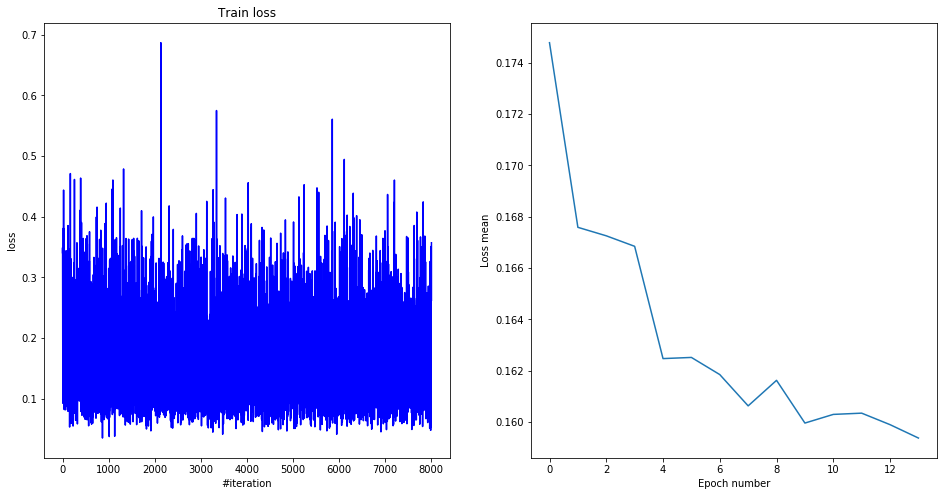

 28%|██▊       | 14/50 [12:50:40<33:01:44, 3302.90s/it]

Training...



Validation...


In [ ]:
for epoch in tqdm(range(num_epochs)):
    start_time = time.time()
    net.train(True)
    print("Training...")
    loss_sum = 0
    
    for X_batch, labels in tqdm_notebook(generate_batches_AR_all(train_data, Train_data_seg, 
                                                train_indices, batch_size=batch_size)):
        cur_loss = []
        X_step = X_batch[0]
        labels_step = labels[0]
        labels_step = labels_step.reshape(labels_step.shape[0], 1, 
                                          labels_step.shape[1], labels_step.shape[2])
        X_step = Variable(X_step)
        labels_step = Variable(labels_step)
        if torch.cuda.is_available():
            X_step = X_step.cuda()
            labels_step = labels_step.cuda()
        out = net(X_step)
        loss = compute_loss(out,def_h,def_w,labels_step,'BCE')
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        cur_loss.append(loss.cpu().data.numpy())
        ar_out = torch.zeros(X_step.shape[0], n_out, def_h, def_w)
        for step in range(n_out - 1):
            X_step = X_batch[step + 1]
            ar_out[:,step] = out.detach().data[:, 0]
            upper = step + 1
            lower = max(upper - n_frames,0)
            X_step[:,-min(upper, n_frames):,:,:] = ar_out[:,lower:upper,:,:]
            
            labels_step = labels[step + 1]
            labels_step = labels_step.reshape(labels_step.shape[0], 1, 
                                          labels_step.shape[1], labels_step.shape[2])

            X_step = Variable(X_step)
            labels_step = Variable(labels_step)
            if torch.cuda.is_available():
                X_step = X_step.cuda()
                labels_step = labels_step.cuda()
            out = net(X_step)
            loss = compute_loss(out,def_h,def_w,labels_step,'BCE')
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            cur_loss.append(loss.cpu().data.numpy())
        loss_num = np.mean(cur_loss)
        loss_sum += loss_num
        train_loss.append(loss_num)

    del loss, X_batch, labels, X_step, labels_step, ar_out, out
    torch.cuda.empty_cache()

    train_loss_mean.append(loss_sum / number_of_batches_train)
    net.eval()
    inner_acc = np.zeros((n_out, number_of_batches_val),dtype = float)
    inner_miou = np.zeros((n_out, number_of_batches_val),dtype = float)
    inner_iou = np.zeros((n_out, number_of_batches_val,n_classes),dtype = float)
    
    print("Validation...")
    counter = 0
    for X_batch, labels in generate_batches_AR_all(val_data, Val_data_seg, 
                                                val_indices, batch_size=batch_size):
        X_step = X_batch[0]
        with torch.no_grad():
            out = net(Variable(X_step).cuda())
        pred = out.cpu().data.numpy()
        pred[pred > 0.5] = 1.0
        pred[pred <= 0.5] = 0.0
                
        pred = pred.reshape(X_step.shape[0], def_h, def_w)
        
        acc_loc,miou_loc,iou_loc = compute_metrics(pred.astype(int),labels[0].numpy().astype(int),
                                                   n_classes=2)
        inner_acc[0,counter] = acc_loc
        inner_miou[0,counter] = miou_loc
        inner_iou[0,counter,:] = iou_loc
        ar_out = torch.zeros(X_step.shape[0], n_out, def_h, def_w)
        for step in range(n_out - 1):
            X_step = X_batch[step + 1]
            ar_out[:,step,:,:] = out.detach().data[:, 0]
            upper = step + 1
            lower = max(upper - n_frames,0)
            X_step[:,-min(upper, n_frames):,:,:] = ar_out[:,lower:upper,:,:]
            X_step = Variable(X_step)
            if torch.cuda.is_available():
                X_step = X_step.cuda()
            out = net(X_step)
            pred = out.cpu().data.numpy()
            pred[pred > 0.5] = 1.0
            pred[pred <= 0.5] = 0.0

            pred = pred.reshape(X_step.shape[0], def_h, def_w)

            acc_loc,miou_loc,iou_loc = compute_metrics(pred.astype(int),labels[step + 1].numpy().astype(int),
                                                       n_classes=2)
            inner_acc[1+step,counter] = acc_loc
            inner_miou[1+step,counter] = miou_loc
            inner_iou[1+step,counter,:] = iou_loc
        counter += 1
    del X_batch, labels, X_step
    torch.cuda.empty_cache()
    
    cur_acc = inner_acc.mean(axis = 1)
    cur_miou = inner_miou.mean(axis = 1)
    cur_iou = inner_iou.mean(axis = 1)
    
    display.clear_output(wait=True)
    
    cur_miou_mean = cur_miou.mean()
    if cur_miou_mean > best_val_miou:
        print("saving model on epoch number %d with val miou %.3f..." % 
             (epoch + 1, cur_miou_mean))
        torch.save(net.state_dict(), 'model_s2s_ar_bce10_finetuned_from_out1.pt')
        best_val_miou = cur_miou_mean
        no_improvements = 0
    else:
        no_improvements += 1
        if no_improvements > no_improvements_threshold:
            print("There were no improvements during last %d epochs,\nending on epoch %d" % 
               (no_improvements_threshold, epoch + 1))
            break
    print("acc = ",cur_acc)
    print("cur_miou = ",cur_miou)
    print("cur_iou = ",cur_iou)
    acc.append(cur_acc)
    miou.append(cur_miou)
    iou.append(cur_iou)
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.plot(train_loss, 'b')
    plt.title("Train loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.subplot(122)
    plt.plot(train_loss_mean)
    plt.xlabel('Epoch number')
    plt.ylabel('Loss mean')
    plt.show()
    
    text = [
        str(cur_miou_mean), ", best: ", str(best_val_miou),
        "\n acc: ", str(cur_acc), '\n cur_miou: ', str(cur_miou), '\n cur_iou: ', str(cur_iou),
        "\n epoch num: ", str(epoch + 1), " took: ", str(time.time() - start_time),
        "\n no_improvements: ", str(no_improvements)
    ]
    send_email("from_nout1_modsize1")
    send_email(''.join(text))

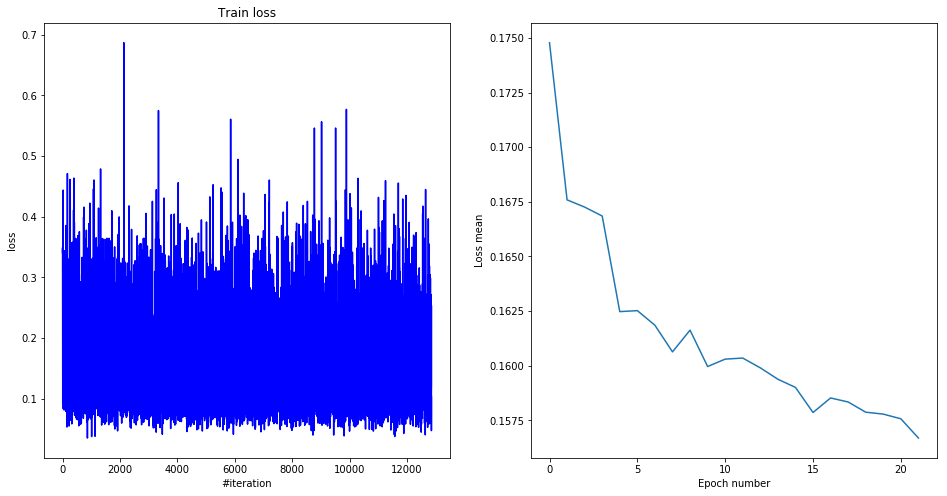

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.plot(train_loss, 'b')
plt.title("Train loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.subplot(122)
plt.plot(train_loss_mean)
plt.xlabel('Epoch number')
plt.ylabel('Loss mean')
plt.show()

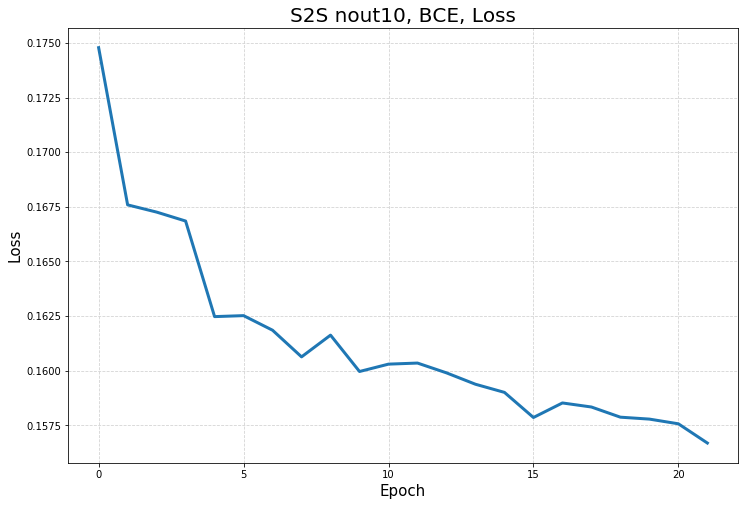

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(train_loss_mean, lw=3)
plt.title("S2S nout10, BCE, Loss", size=20)
plt.xlabel("Epoch", size=15)
plt.ylabel("Loss", size=15)
plt.grid(color='lightgray', linestyle='dashed')
plt.show()

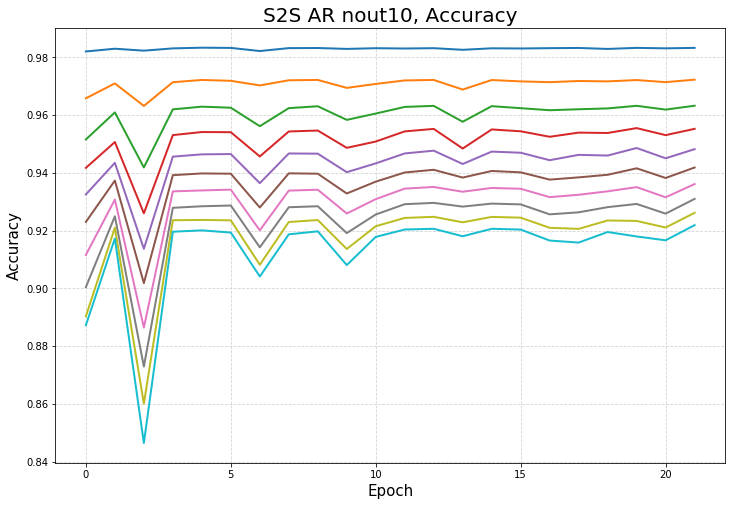

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(acc), lw=2)
plt.title("S2S AR nout10, Accuracy", size=20)
plt.xlabel("Epoch", size=15)
plt.ylabel("Accuracy", size=15)
plt.grid(color='lightgray', linestyle='dashed')
plt.show()

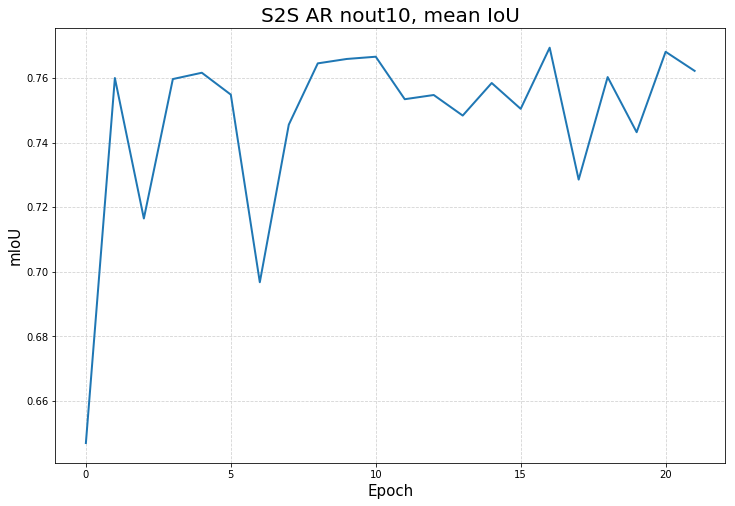

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(miou).mean(1), lw=2)
plt.title("S2S AR nout10, mean IoU", size=20)
plt.xlabel("Epoch", size=15)
plt.ylabel("mIoU", size=15)
plt.grid(color='lightgray', linestyle='dashed')
plt.show()

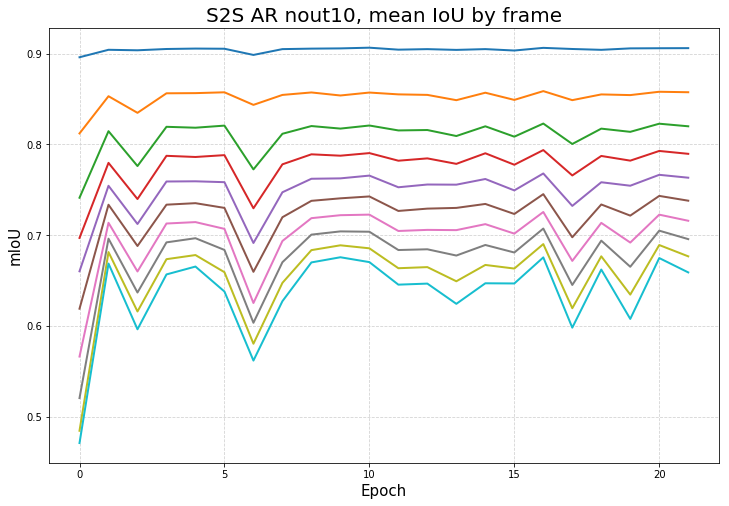

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(miou), lw=2)
plt.title("S2S AR nout10, mean IoU by frame", size=20)
plt.xlabel("Epoch", size=15)
plt.ylabel("mIoU", size=15)
plt.grid(color='lightgray', linestyle='dashed')
plt.show()

In [62]:
max_ind = np.argmax([np.array(iou)[i].mean() for i in range(epoch)])

In [63]:
max_ind

16

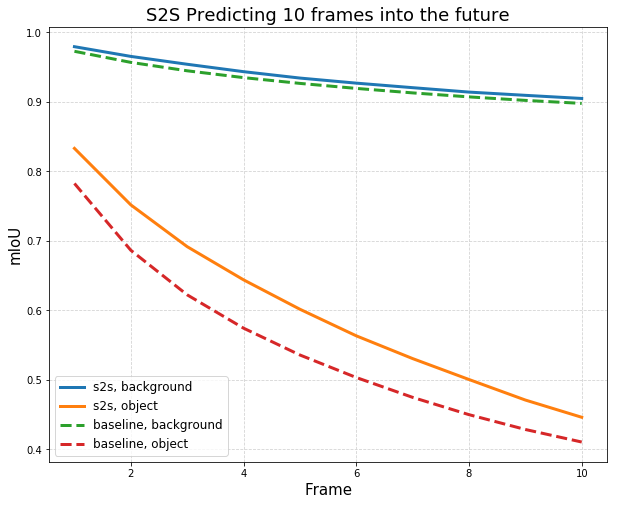

In [72]:
plt.figure(figsize=(10, 8))
lw = 3
x = range(1, 11)
plt.plot(x, np.array(iou)[max_ind][:,0], label='s2s, background', lw=lw)
plt.plot(x, np.array(iou)[max_ind][:,1], label='s2s, object', lw=lw)
plt.plot(x, res_baseline[2][:,0], label='baseline, background', lw=lw, linestyle='--')
plt.plot(x, res_baseline[2][:,1], label='baseline, object', lw=lw, linestyle='--')
plt.xlabel('Frame', size=15)
plt.ylabel('mIoU', size=15)
plt.title('S2S Predicting 10 frames into the future', size=18)
plt.grid(color='lightgray', linestyle='dashed')
plt.legend(prop={"size":12})
plt.show()

### For gifs:

In [20]:
net.load_state_dict(torch.load("model_s2s_ar_bce10_finetuned_from_out1.pt"))

In [24]:
batch_size = 2

In [25]:
batch_ind = 0

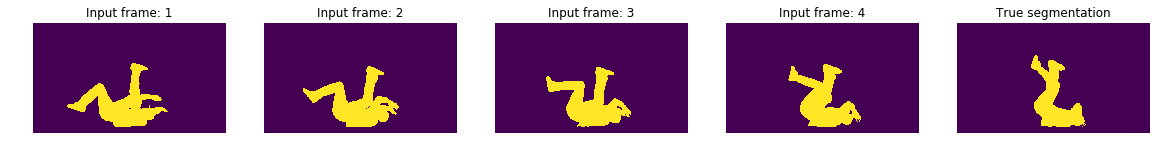

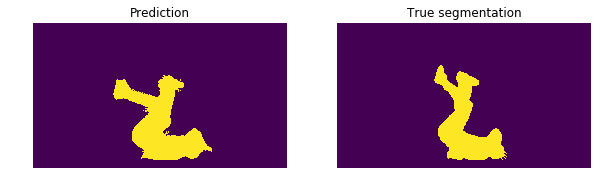

1


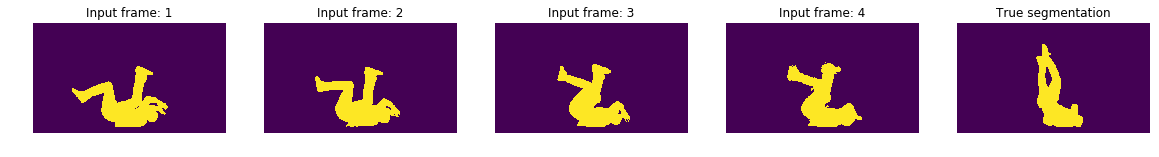

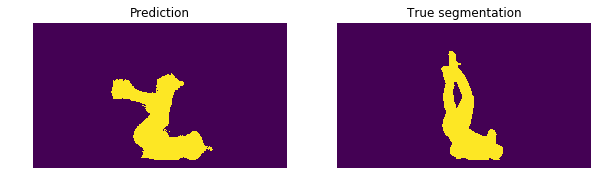

2


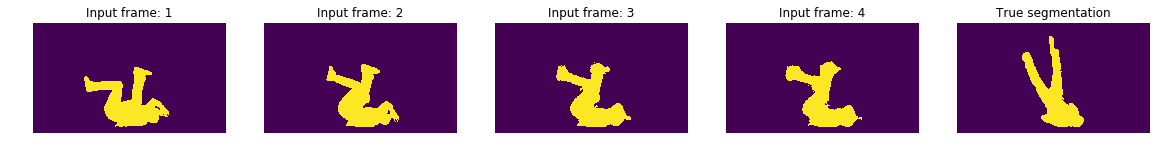

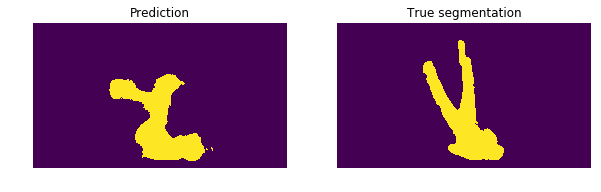

3


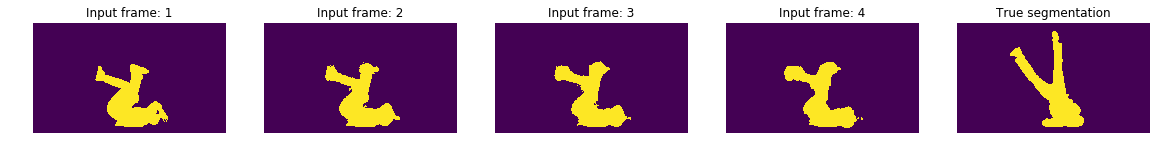

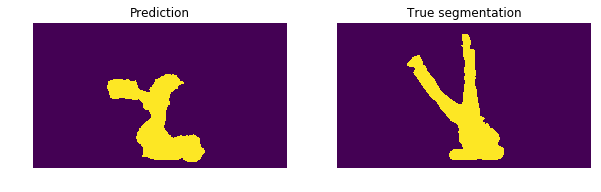

4


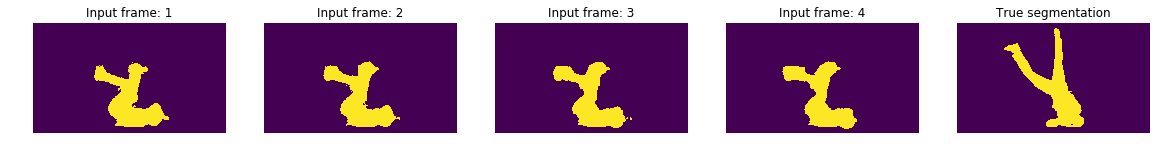

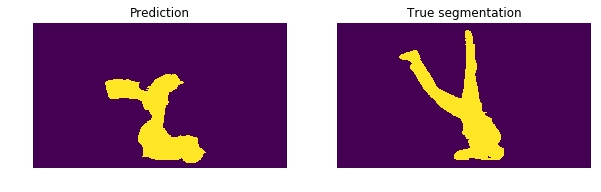

5


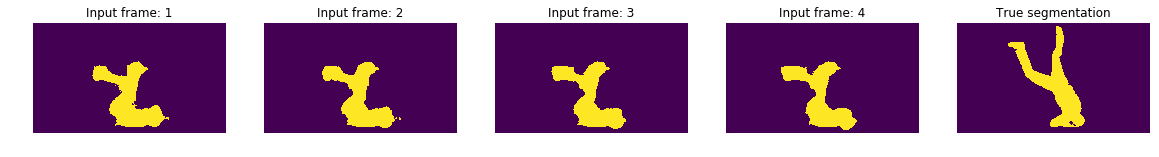

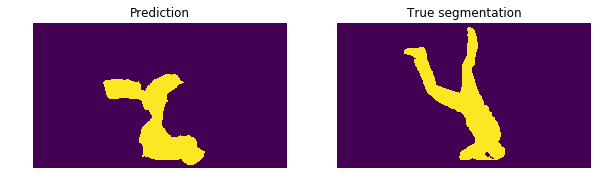

6


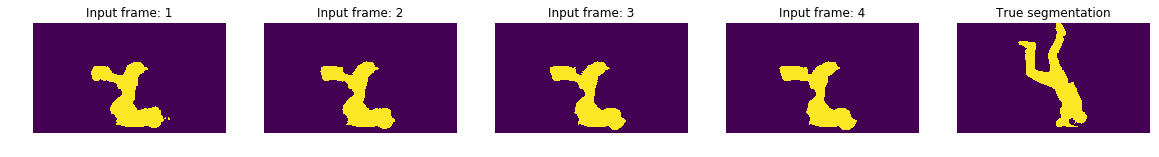

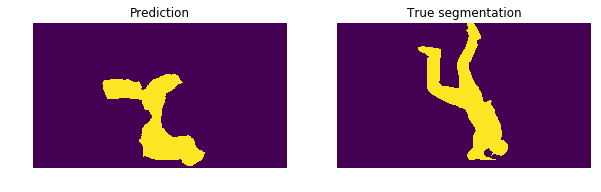

7


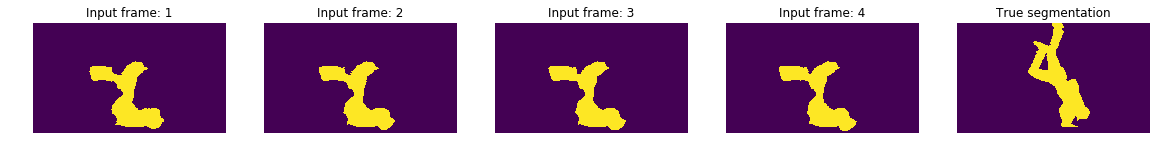

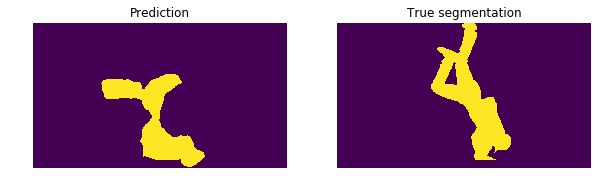

8


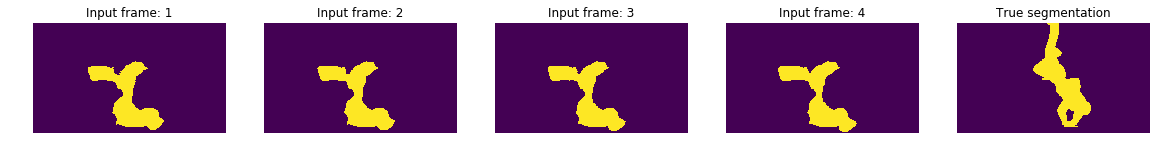

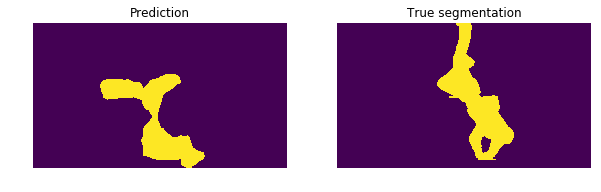

9


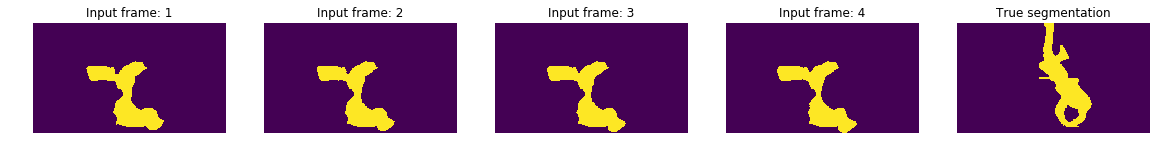

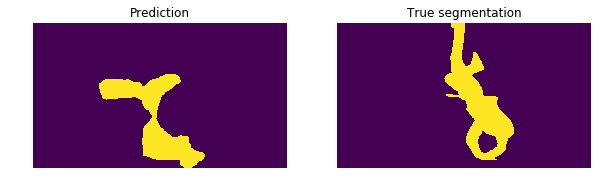

10


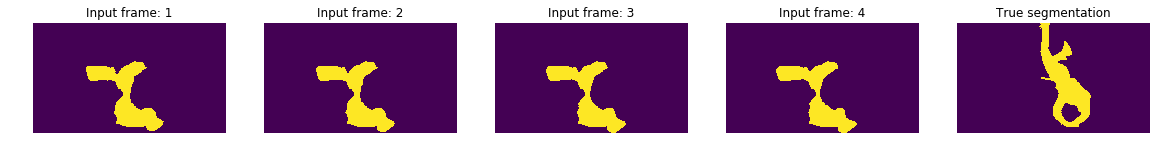

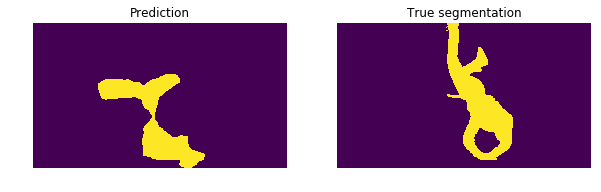

11


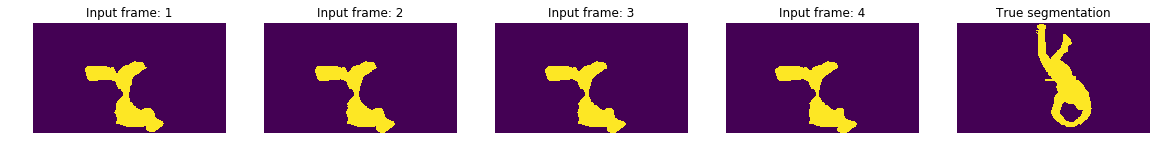

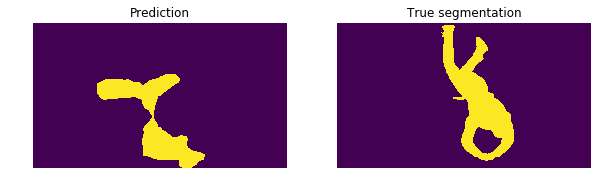

12


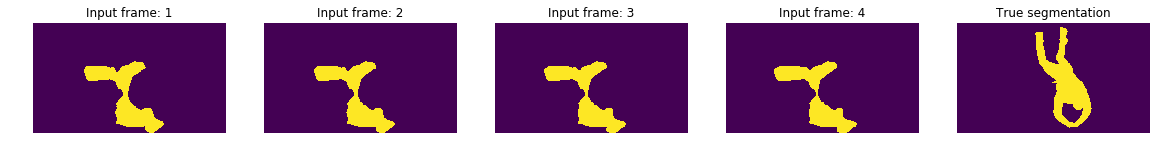

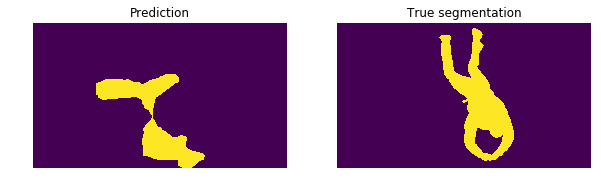

13


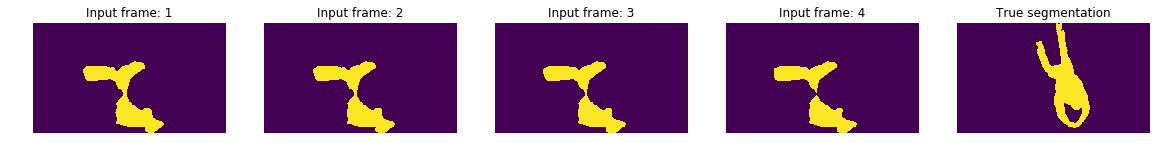

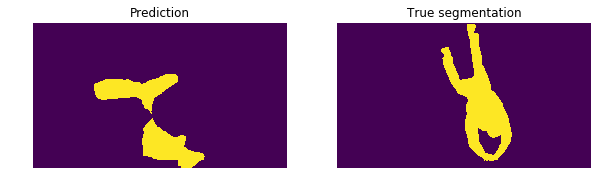

14


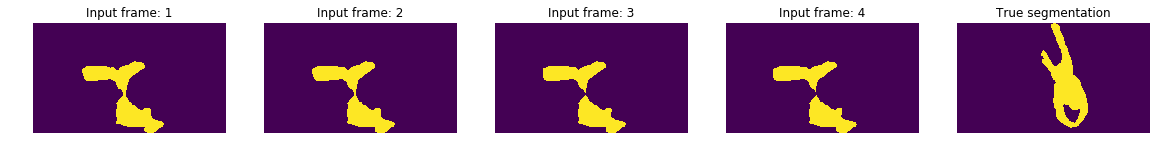

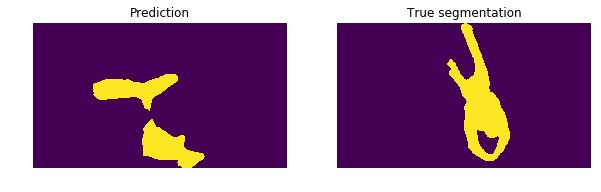

15


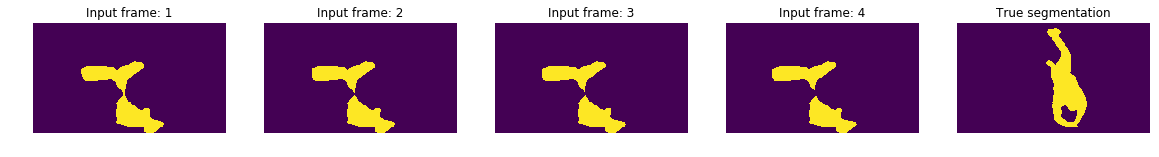

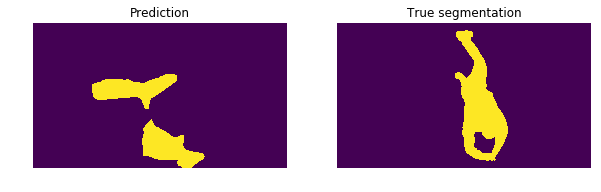

16


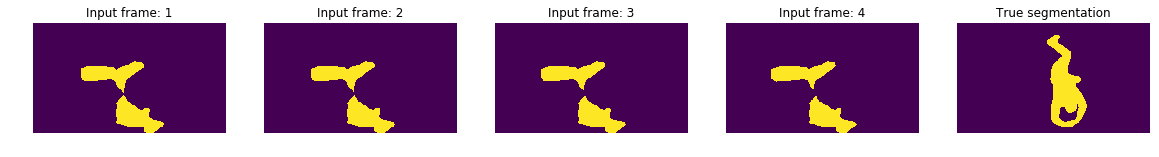

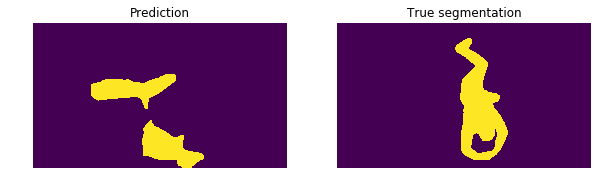

17


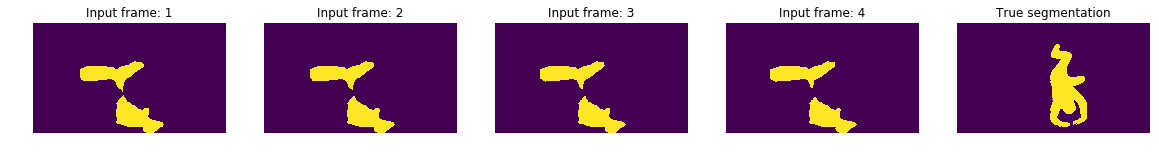

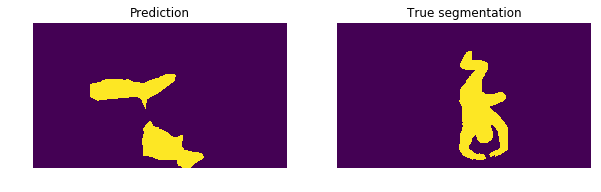

18


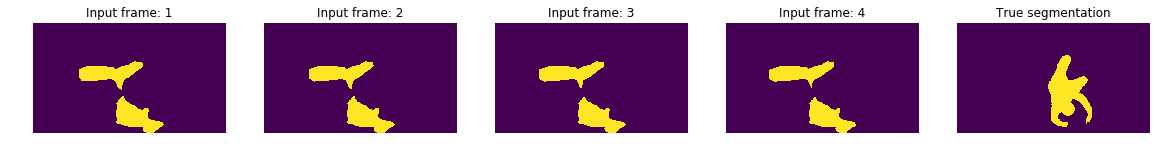

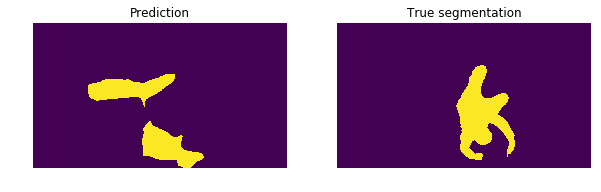

19


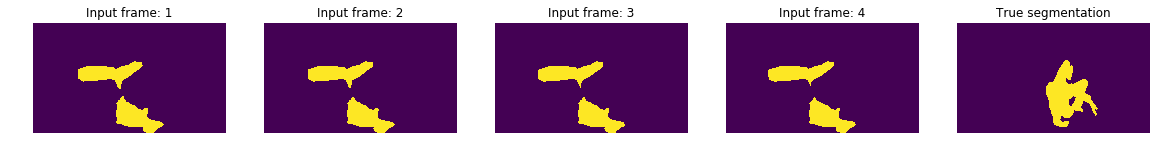

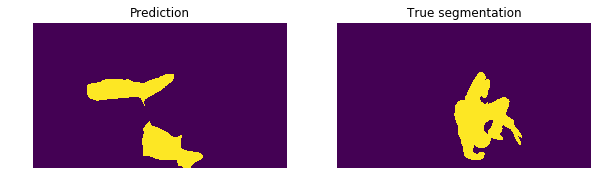

In [44]:
net.eval()
inner_acc = np.zeros((n_out, number_of_batches_val),dtype = float)
inner_miou = np.zeros((n_out, number_of_batches_val),dtype = float)
inner_iou = np.zeros((n_out, number_of_batches_val,n_classes),dtype = float)

counter = 0

predictions = []
true_labels = []
for X_batch, labels in generate_batches_AR_all(val_data, Val_data_seg, 
                                                val_indices, batch_size=batch_size):
    X_step = X_batch[0,:,:,:,:]
    with torch.no_grad():
        out = net(Variable(X_step).cuda())
    pred = out.cpu().data.numpy()
    pred[pred > 0.5] = 1.0
    pred[pred <= 0.5] = 0.0    
    pred = pred.reshape(X_step.shape[0], def_h, def_w)
    
    predictions.append(pred.astype(int))
    true_labels.append(labels[0,:,:,:].numpy().astype(int))

    acc_loc,miou_loc,iou_loc = compute_metrics(pred.astype(int),labels[0,:,:,:].numpy().astype(int),
                                               n_classes=2)
    inner_acc[0,counter] = acc_loc
    inner_miou[0,counter] = miou_loc
    inner_iou[0,counter,:] = iou_loc
    ar_out = torch.zeros(X_step.shape[0], n_out, def_h, def_w)
    
    plt.figure(figsize=(20, 5))
    for i in range(4):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X_batch[0, batch_ind, i])
        plt.title("Input frame: %d" % (i + 1))
        plt.axis('off')
    plt.subplot(1, 5, 5)
    plt.imshow(labels[0, batch_ind])
    plt.title("True segmentation")
    plt.axis('off')
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(pred.astype(int)[batch_ind])
    plt.title("Prediction")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, batch_ind])
    plt.title("True segmentation")
    plt.axis('off')
    plt.show()
    
    
    for step in range(n_out-1):
        print(step + 1)
        X_step = X_batch[1+step,:,:,:,:]
        out_pred = out.detach().data[:, 0]
        out_pred[out_pred > 0.5] = 1.0
        out_pred[out_pred <= 0.5] = 0.0
        
        ar_out[:,step,:,:] = out_pred
        upper = step + 1
        lower = max(upper-n_frames,0)
        X_step[:,-min(upper,n_frames):,:,:] = ar_out[:,lower:upper,:,:]
        X_step = Variable(X_step)
        if torch.cuda.is_available():
            X_step = X_step.cuda()
        out = net(X_step)
        pred = out.cpu().data.numpy()
        pred[pred > 0.5] = 1.0
        pred[pred <= 0.5] = 0.0

        pred = pred.reshape(X_step.shape[0], def_h, def_w)
        
        predictions.append(pred.astype(int))
        true_labels.append(labels[1+step,:,:,:].numpy().astype(int))
        
        plt.figure(figsize=(20, 5))
        for i in range(4):
            plt.subplot(1, 5, i + 1)
            plt.imshow(X_batch[step+1, batch_ind, i])
            plt.title("Input frame: %d" % (i + 1))
            plt.axis('off')
        plt.subplot(1, 5, 5)
        plt.imshow(labels[step+1, batch_ind])
        plt.title("True segmentation")
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(pred.astype(int)[batch_ind])
        plt.title("Prediction")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(labels[step+1, batch_ind])
        plt.title("True segmentation")
        plt.axis('off')
        plt.show()
        
        acc_loc,miou_loc,iou_loc = compute_metrics(pred.astype(int),labels[1+step,:,:,:].numpy().astype(int),
                                                       n_classes=2)
        inner_acc[1+step,counter] = acc_loc
        inner_miou[1+step,counter] = miou_loc
        inner_iou[1+step,counter,:] = iou_loc
    break
cur_acc = inner_acc.mean(axis = 1)
cur_miou = inner_miou.mean(axis = 1)
cur_iou = inner_iou.mean(axis = 1)
cur_miou_mean = cur_miou.mean()

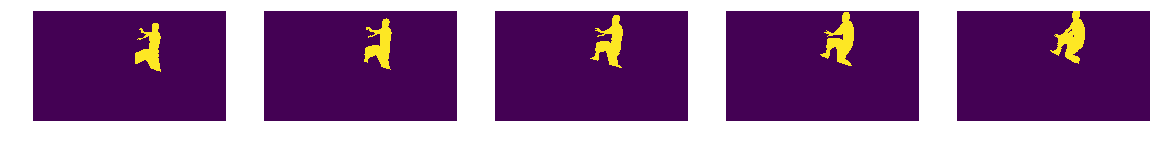

In [115]:
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_batch[0, batch_ind, i])
    plt.axis('off')
plt.subplot(1, 5, 5)
plt.imshow(labels[0, batch_ind])
plt.axis('off')
plt.show()

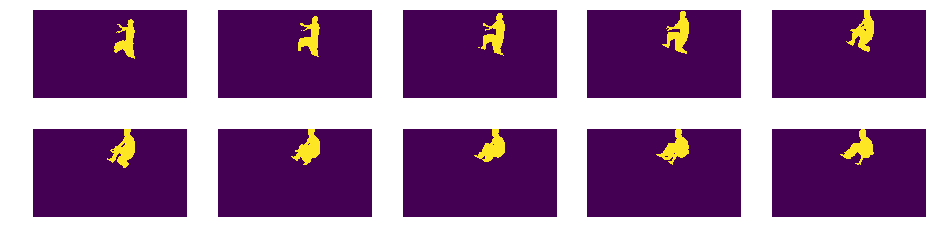

In [61]:
plt.figure(figsize=(16, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_batch[i, batch_ind, 0])
    plt.axis('off')
plt.show()

In [28]:
def save_files(acc, miou, iou, train_loss, train_loss_mean, path):
    d = {
        "acc": [list(x) for x in acc],
        "iou": [list(y) for x in iou for y in x],
        "miou": [list(x) for x in miou],
        "loss": [float(x) for x in train_loss],
        "loss_mean": [float(x) for x in train_loss_mean]
    }
    with open(path, 'w') as f:
        json.dump(d, f)

path = 'saved_files/s2s_ar_bce_nout10_finetuned_from1.json'
save_files(acc, miou, iou, train_loss, train_loss_mean, path)

In [53]:
def compute_baseline():
    inner_acc = np.zeros((n_out, number_of_batches_val),dtype = float)
    inner_miou = np.zeros((n_out, number_of_batches_val),dtype = float)
    inner_iou = np.zeros((n_out, number_of_batches_val,n_classes),dtype = float)
    
    print("Baseline...")
    counter = 0
    for X_batch, labels in generate_batches_AR_all(val_data, Val_data_seg, 
                                                val_indices, batch_size=batch_size):
        X_step = X_batch[0]
        pred = X_step[:,-1].data.numpy()
        acc_loc,miou_loc,iou_loc = compute_metrics(pred.astype(int),labels[0].numpy().astype(int),
                                                   n_classes=2)
        inner_acc[0,counter] = acc_loc
        inner_miou[0,counter] = miou_loc
        inner_iou[0,counter,:] = iou_loc
        for step in range(n_out - 1):
            acc_loc,miou_loc,iou_loc = compute_metrics(pred.astype(int),labels[step + 1].numpy().astype(int),
                                                       n_classes=2)
            inner_acc[1+step,counter] = acc_loc
            inner_miou[1+step,counter] = miou_loc
            inner_iou[1+step,counter,:] = iou_loc
        counter += 1
    cur_acc = inner_acc.mean(axis = 1)
    cur_miou = inner_miou.mean(axis = 1)
    cur_iou = inner_iou.mean(axis = 1)
    return cur_acc, cur_miou, cur_iou

In [54]:
res_baseline = compute_baseline()

Baseline...


In [80]:
d = {
    "acc": res_baseline[0].tolist(),
    "iou": res_baseline[2].tolist(),
    "miou": res_baseline[1].tolist(),
}
path = 'saved_files/s2s_ar_nout10_baseline.json'
with open(path, 'w') as f:
    json.dump(d, f)

In [20]:
net.load_state_dict(torch.load("model_s2s_ar_bce10_finetuned_from_out1.pt"))

In [21]:
def validate(net):
    net.eval()
    inner_acc = np.zeros((n_out, number_of_batches_val),dtype = float)
    inner_miou = np.zeros((n_out, number_of_batches_val),dtype = float)
    inner_iou = np.zeros((n_out, number_of_batches_val,n_classes),dtype = float)

    print("Validation...")
    counter = 0
    for X_batch, labels in generate_batches_AR_all(val_data, Val_data_seg, 
                                                val_indices, batch_size=batch_size):
        X_step = X_batch[0]
        with torch.no_grad():
            out = net(Variable(X_step).cuda())
        pred = out.cpu().data.numpy()
        pred[pred > 0.5] = 1.0
        pred[pred <= 0.5] = 0.0

        pred = pred.reshape(X_step.shape[0], def_h, def_w)

        acc_loc,miou_loc,iou_loc = compute_metrics(pred.astype(int),labels[0].numpy().astype(int),
                                                   n_classes=2)
        inner_acc[0,counter] = acc_loc
        inner_miou[0,counter] = miou_loc
        inner_iou[0,counter,:] = iou_loc
        ar_out = torch.zeros(X_step.shape[0], n_out, def_h, def_w)
        for step in range(n_out - 1):
            X_step = X_batch[step + 1]
            ar_out[:,step,:,:] = out.detach().data[:, 0]
            upper = step + 1
            lower = max(upper - n_frames,0)
            X_step[:,-min(upper, n_frames):,:,:] = ar_out[:,lower:upper,:,:]
            X_step = Variable(X_step)
            if torch.cuda.is_available():
                X_step = X_step.cuda()
            out = net(X_step)
            pred = out.cpu().data.numpy()
            pred[pred > 0.5] = 1.0
            pred[pred <= 0.5] = 0.0

            pred = pred.reshape(X_step.shape[0], def_h, def_w)

            acc_loc,miou_loc,iou_loc = compute_metrics(pred.astype(int),labels[step + 1].numpy().astype(int),
                                                       n_classes=2)
            inner_acc[1+step,counter] = acc_loc
            inner_miou[1+step,counter] = miou_loc
            inner_iou[1+step,counter,:] = iou_loc
        counter += 1
    del X_batch, labels, X_step
    torch.cuda.empty_cache()

    cur_acc = inner_acc.mean(axis = 1)
    cur_miou = inner_miou.mean(axis = 1)
    cur_iou = inner_iou.mean(axis = 1)
    return cur_acc, cur_miou, cur_iou

In [19]:
n_out

20

In [22]:
res_nout20 = validate(net)

Validation...


In [45]:
res_nout20

(array([0.98433528, 0.97307415, 0.96380944, 0.95498551, 0.94718394,
        0.94058845, 0.93463851, 0.92873014, 0.92386554, 0.91939143,
        0.91518374, 0.91172698, 0.90861598, 0.90584232, 0.90313254,
        0.90075298, 0.89830632, 0.89602933, 0.89376345, 0.8914723 ]),
 array([0.90972176, 0.86266179, 0.82732158, 0.79817724, 0.77243183,
        0.74929187, 0.72941436, 0.7107869 , 0.6930252 , 0.67826933,
        0.66420271, 0.65181669, 0.63975562, 0.62959232, 0.61914555,
        0.60970633, 0.60118623, 0.59315519, 0.5852634 , 0.57802104]),
 array([[0.98134158, 0.83810194],
        [0.96813667, 0.75718691],
        [0.95745389, 0.69718927],
        [0.94729505, 0.64905942],
        [0.93845944, 0.60640422],
        [0.93129394, 0.56728979],
        [0.92485316, 0.53397555],
        [0.91851563, 0.50305818],
        [0.91358909, 0.47246131],
        [0.90899999, 0.44753867],
        [0.90469231, 0.42371311],
        [0.90128955, 0.40234383],
        [0.89826564, 0.3812456 ],
        [0